# Deconvolve simulated data with and without trajectory learning

In this tutorial we simulated data from a random but fixed trajectory with differing number of samples in each dataset and we assess the normalized L1 error as the number of samples changes.

In [2]:
# load libraries
import torch
import seaborn as sns
from ternadecov.simulator import *
from ternadecov.time_deconv import *
from ternadecov.time_deconv import *
from ternadecov.simulator import *
from ternadecov.stats_helpers import *
from ternadecov.dataset import *
from ternadecov.deconvolution_plotter import *
from ternadecov.parametrization import *
from ternadecov.evaluation import evaluate_with_trajectory
from ternadecov.deconvolution_writer import DeconvolutionWriter
from ternadecov.deconvolution_exporter import DeconvolutionExporter

### Configure

We set up the deconvolution with a small number of iterations for brevity

In [3]:
n_iters = 5_000

### Load data

We start by loading the single-cell data that we will use as a reference for generating the simulated bulk dataset.

In [4]:
sc_anndata_path = "/home/nbarkas/disk2/deconvolution_method/datasets/ebov/load_data_python/ebov_sc.h5ad"

In [5]:
with open(sc_anndata_path, 'rb') as fh:
    sc_anndata = anndata.read_h5ad(fh)

In [6]:
types = DeconvolutionDatatypeParametrization()

ebov_sc_dataset = SingleCellDataset(
    sc_anndata, 
    sc_celltype_col="Subclustering_reduced", 
    dtype_np=types.dtype_np, dtype = types.dtype, device=types.device)

## Simulation of trajectory

We next generate a single fixed trajectory from which we will sample increasing number of samples. We use a fixed trajectory because the shape of the trajectory can affect the number of samples requied to  achive comparable L1 error between trajectories.

In [7]:
# trajectory generating function
trajectory_type = 'periodic'

In [8]:
# Use a single trajectory for all iterations
trajectory_coef = sample_trajectories(
    type = trajectory_type,
    num_cell_types = ebov_sc_dataset.num_cell_types,
    seed=2022
)

In [9]:
sim_res = simulate_data(
    w_hat_gc = torch.Tensor(ebov_sc_dataset.w_hat_gc),
    trajectory_type=trajectory_type,
    num_samples=20, 
    trajectory_coef=trajectory_coef,
    seed=2022)

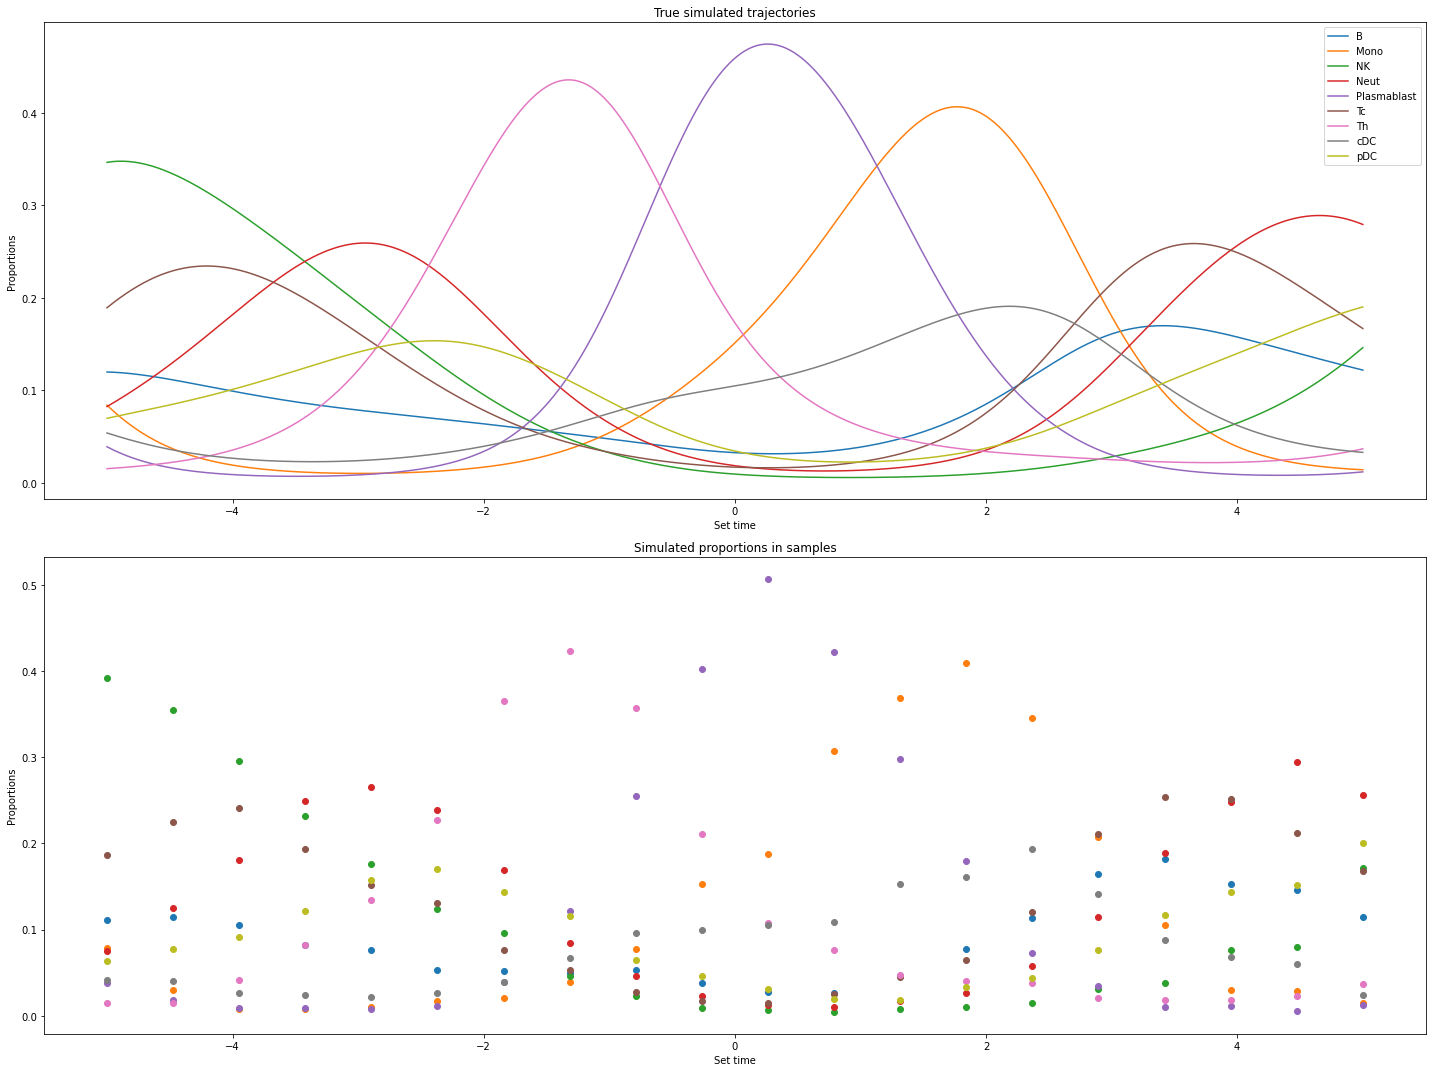

In [10]:
plot_simulated_proportions(sim_res, ebov_sc_dataset, figsize=(20,15))
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

In [11]:
datatype_param = DeconvolutionDatatypeParametrization()

In [13]:
# Deconvolve this with the Non-trajectory trajectory

In [15]:
simulated_bulk = generate_anndata_from_sim(
    sim_res, 
    sc_dataset=ebov_sc_dataset)

In [16]:
# Make a deconvolution dataset
ebov_simulated_dataset = DeconvolutionDataset(
    types=datatype_param,
    parametrization = DeconvolutionDatasetParametrization(
        sc_anndata = sc_anndata,
        sc_celltype_col = "Subclustering_reduced",
        bulk_anndata = simulated_bulk,
        bulk_time_col = "time",
    )       
)

/home/nbarkas/disk1/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.44033e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


2906 genes selected


In [77]:
n_trials = 7

In [78]:
true_prop = sim_res['cell_pop_cm'].T

In [79]:
# df_repl = []
# df_type = []
# df_norm_l1 = []

In [80]:
for n in range(n_trials):
    pyro.clear_param_store()
    
    pseudo_time_reg_deconv_sim = TimeRegularizedDeconvolutionModel(
        dataset=ebov_simulated_dataset,
        trajectory_model_type='nontrajectory',
        hyperparameters=TimeRegularizedDeconvolutionModelParametrization(),
        trajectory_hyperparameters=TimeRegularizedDeconvolutionGPParametrization(),
        types=datatype_param)
    pseudo_time_reg_deconv_sim.fit_model(n_iters=n_iters, verbose=True, log_frequency=1000,keep_param_store_history=False)
    

    estimated = torch.nn.functional.softmax(pyro.param("unnorm_cell_pop_loc_posterior_mc").detach(),0)
    
    norm_l1_error = (true_prop - estimated).abs().sum() / estimated.shape[0]
    
    df_repl.append(n)
    df_type.append('nontrajectory')
    df_norm_l1.append(norm_l1_error)

[step: 0, time: 1 s ] loss: 791296.06
[step: 1000, time: 10 s ] loss: 486518.49
[step: 2000, time: 19 s ] loss: 360848.10
[step: 3000, time: 28 s ] loss: 322237.10
[step: 4000, time: 37 s ] loss: 306286.76
[step: 0, time: 1 s ] loss: 751645.18
[step: 1000, time: 10 s ] loss: 479509.71
[step: 2000, time: 19 s ] loss: 359976.16
[step: 3000, time: 28 s ] loss: 320976.94
[step: 4000, time: 37 s ] loss: 306396.09
[step: 0, time: 1 s ] loss: 802811.18
[step: 1000, time: 10 s ] loss: 478398.82
[step: 2000, time: 19 s ] loss: 360624.70
[step: 3000, time: 28 s ] loss: 322252.68
[step: 4000, time: 37 s ] loss: 306224.66
[step: 0, time: 1 s ] loss: 752644.87
[step: 1000, time: 10 s ] loss: 479974.07
[step: 2000, time: 19 s ] loss: 361563.50
[step: 3000, time: 28 s ] loss: 320790.39
[step: 4000, time: 37 s ] loss: 306435.18
[step: 0, time: 1 s ] loss: 785147.43
[step: 1000, time: 10 s ] loss: 477830.60
[step: 2000, time: 19 s ] loss: 364241.02
[step: 3000, time: 28 s ] loss: 321533.64
[step: 4000,

In [81]:
for n in range(n_trials):
    pyro.clear_param_store()
    
    pseudo_time_reg_deconv_sim = TimeRegularizedDeconvolutionModel(
        dataset=ebov_simulated_dataset,
        trajectory_model_type='gp',
        hyperparameters=TimeRegularizedDeconvolutionModelParametrization(),
        trajectory_hyperparameters=TimeRegularizedDeconvolutionGPParametrization(),
        types=datatype_param)
    
    pseudo_time_reg_deconv_sim.fit_model(n_iters=n_iters, verbose=True, log_frequency=1000,keep_param_store_history=False)
    
    estimated = (
        pseudo_time_reg_deconv_sim.population_proportion_model.guide(torch.Tensor([]))
        .clone()
        .detach()
        .cpu()
    )
    
    norm_l1_error = (true_prop - estimated).abs().sum() / estimated.shape[0]
    
    df_repl.append(n)
    df_type.append('gp')
    df_norm_l1.append(norm_l1_error)   

[step: 0, time: 1 s ] loss: 788340.91
[step: 1000, time: 15 s ] loss: 458902.08
[step: 2000, time: 29 s ] loss: 357437.33
[step: 3000, time: 43 s ] loss: 320744.83
[step: 4000, time: 57 s ] loss: 306403.39
[step: 0, time: 1 s ] loss: 804076.00
[step: 1000, time: 15 s ] loss: 482606.75
[step: 2000, time: 29 s ] loss: 363175.10
[step: 3000, time: 43 s ] loss: 321505.97
[step: 4000, time: 57 s ] loss: 306601.42
[step: 0, time: 1 s ] loss: 775140.72
[step: 1000, time: 15 s ] loss: 472749.33
[step: 2000, time: 29 s ] loss: 361268.40
[step: 3000, time: 43 s ] loss: 321476.12
[step: 4000, time: 57 s ] loss: 306874.63
[step: 0, time: 1 s ] loss: 794546.83
[step: 1000, time: 15 s ] loss: 468968.19
[step: 2000, time: 29 s ] loss: 360069.53
[step: 3000, time: 43 s ] loss: 320210.02
[step: 4000, time: 57 s ] loss: 306917.48
[step: 0, time: 1 s ] loss: 792461.56
[step: 1000, time: 15 s ] loss: 471603.99
[step: 2000, time: 29 s ] loss: 360199.75
[step: 3000, time: 43 s ] loss: 321189.31
[step: 4000,

## Plot

In [89]:
data = pd.DataFrame({'repl': df_repl, 'type': df_type, 'norm_l1': (x.item() for x in df_norm_l1)})

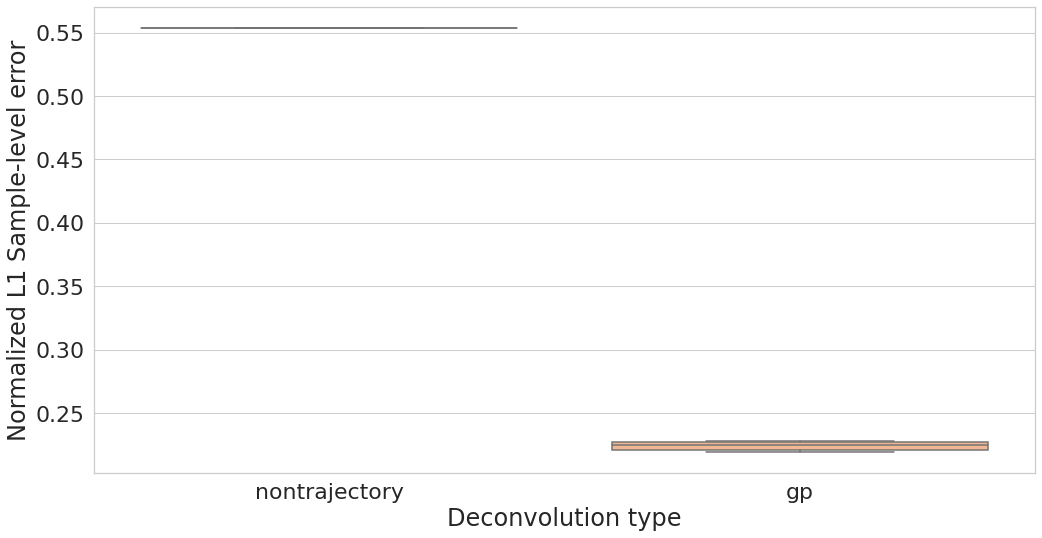

In [92]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.set_theme(style="whitegrid", palette="pastel",font_scale = 2)
plt1 = sns.boxplot(data=data, x='type', y='norm_l1')
plt1.set_ylabel('Normalized L1 Sample-level error')
plt1.set_xlabel('Deconvolution type')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()